In [1]:
import numpy as np

In [2]:
# env_name = 'InvertedPendulum-v2'
env_name = 'RLCar-v0'
alg_name = 'ERL'
# alg_name = 'DDPG'
# alg_name = 'SimpleES'
name = 'map3-first-non-trivial'

np.random.seed(hash(f'{env_name}-{alg_name}-{name}')%(2**32))

In [3]:
import math
import gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from datetime import datetime
import pathlib

from ddpg import DDPG
from erl import ERL
from es import SimpleES

from car_env import CarEnv

In [4]:
pathlib.Path('buffers').mkdir(parents=True, exist_ok=True)
pathlib.Path('models' ).mkdir(parents=True, exist_ok=True)

env = None
if env_name == 'RLCar-v0':
    env = CarEnv(file_name = 'maps/map3.txt', num_rays = 12)
else:
    env = gym.make(env_name)

In [5]:
state_size = int(np.prod(env.observation_space.shape))
action_size = int(np.prod(env.action_space.shape))
if alg_name != 'SimpleES':
    try:
        actor  = tf.keras.models.load_model(f'models/{env_name}/{alg_name}-{name}-actor')
        critic = tf.keras.models.load_model(f'models/{env_name}/{alg_name}-{name}-critic')
        print('Models loaded from disk')

    except OSError:
        try:
            action_high = float(env.action_space.high)
        except:
            action_high = float(env.action_space.high[0])

        actor = Sequential([
            Input(state_size),
            # Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            Dense(action_size, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            Lambda(lambda x: x*action_high)
        ])
        critic = Sequential([
            Input(state_size+action_size),
            # Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            Dense(1)
        ])
        print('Fresh models created')

Fresh models created


In [6]:
# current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# train_log_dir = 'logs/' + current_time + '/train'
# test_log_dir = 'logs/' + current_time + '/test'
# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [7]:
adam = Adam()
action_noise = lambda x: 10**(-3-2*x) # from 0.001 to 0.00001
# alg = DDPG(env, actor, critic, adam, name = name, actions_per_epoch=4, training_steps_per_epoch=4,
#     action_noise = action_noise, buffer_size=10**4) #, train_summary_writer = train_summary_writer, test_summary_writer = test_summary_writer)
alg = ERL(env, actor, critic, adam, name = name, episodes_per_actor=1, episodes_rl_actor=5, training_steps_per_epoch=10,
    action_noise = action_noise, mutation_rate = 0.005, buffer_size = 10**5) #, train_summary_writer = train_summary_writer, test_summary_writer = test_summary_writer)
# alg = SimpleES(env, num_actors=40, num_features=state_size, num_outputs=action_size, activation_function=np.tanh, mutation_rate=0.1)

Buffer loaded from disk


In [8]:
try:
    stats = alg.train(epochs=400, batch_size=256, test_every=5, render_test=True)

except (KeyboardInterrupt, SystemExit) as e:
    print('Interrupted')
    stats = alg.stats

# alg.buffer.save_to_file()
# alg.save_models()
alg.env.close()

 16%|█▌        | 64/400 [01:16<06:41,  1.20s/it, test_fitness=-115]Interrupted



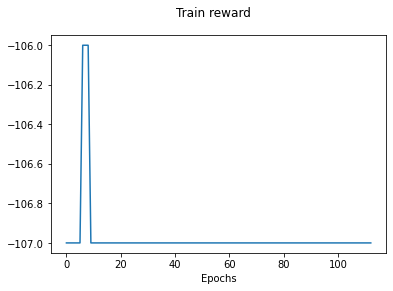

In [9]:
plt.plot(stats['reward'])
plt.suptitle('Train reward')
plt.xlabel('Epochs')
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{directory}/train_reward_{name}.jpg')

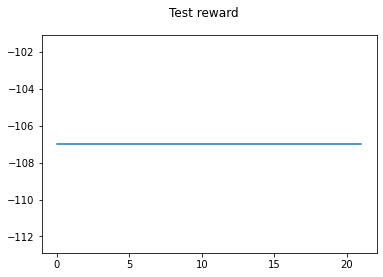

In [10]:
plt.plot(stats['test_reward'])
plt.suptitle('Test reward')
# plt.xlabel('Hundreds of epochs')
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{directory}/test_reward_{name}.jpg')

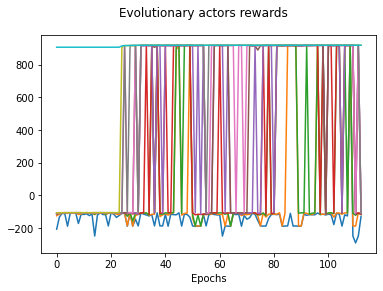

In [13]:
actors_rewards = np.array(stats['actors_rewards'])
mean = np.mean(actors_rewards, axis=1)
low  = np.min(actors_rewards, axis=1)
high = np.max(actors_rewards, axis=1)

# plt.fill_between(np.arange(len(mean)), low, high)
# plt.plot(mean, 'r')
plt.plot(actors_rewards)
# plt.ylim(-140, -80)
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)

plt.suptitle('Evolutionary actors rewards')
plt.xlabel('Epochs')

plt.savefig(f'{directory}/actors_reward_{name}.jpg')
